In [206]:
import os
from pathlib import Path

import cv2
import matplotlib
import numpy as np
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from ultralytics import YOLO

from utils.preprocess import get_image_by_labels, get_labels_by_image
from utils.preprocess import xyxy_reformat, rect_include_another

matplotlib.use('module://matplotlib_inline.backend_inline')
# %matplotlib inline
load_dotenv()


True

In [207]:
target_labels = ['caries', 'endo', 'post', 'crown']
image_labels_df = get_image_by_labels(target_labels)[target_labels]

image_labels_df


,caries,endo,post,crown
filename,,,,
20180716060731353968_000351,0,1,1,1
202011280311178751869_0460103A,0,15,2,17
201806270806586650_000063,0,4,0,2
201808060608235842214_000582,5,0,0,0
202011200611597931737_0701103A,0,2,0,0
...,...,...,...,...
00008336,0,4,1,3
201806280906437051_000067,0,0,1,1
201809100509288484538_000846,1,1,0,0


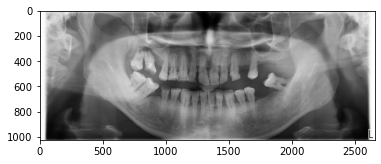

In [208]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'

filename = image_labels_df.index[3]
filepath_image = data_dir / f'{filename}.jpg'
filepath_json = data_dir / f'{filename}.json'

im_0 = cv2.imread(filepath_image)
plt.imshow(im_0)
plt.show()


# Demo rotation

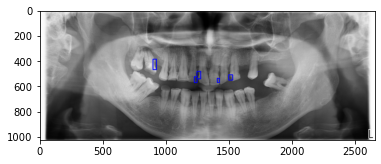

In [209]:
labels = get_labels_by_image(filepath_json, target_labels)
colors_dict = {target_labels[i - 1]: [int(j) * 255 for j in bin(i)[2:].zfill(3)] for i in
               range(1, len(target_labels) + 1)}

im_annotated = im_0.copy()

for label in labels:
    xyxy = np.array([np.hstack(label['points'])]).astype(int)
    xyxy = xyxy_reformat(xyxy)[0]
    color = colors_dict[label['label']]

    im_annotated = cv2.rectangle(im_annotated, xyxy[:2], xyxy[2:], color, thickness=5)

plt.imshow(im_annotated)
plt.show()


In [217]:
yolo_model_dir = Path(os.getenv('YOLO_MODEL_DIR'))
yolo_dir = yolo_model_dir / '..'
model = YOLO(yolo_model_dir / 'enumerate.pt')
# Image
# Inference
results = model(filepath_image, save_crop=True)



image 1/1 /Users/lucyxu/PycharmProjects/datasets/phase-2/201808060608235842214_000582.jpg: 256x640 1 11, 1 12, 1 13, 1 14, 1 15, 1 17, 1 18, 2 21s, 2 22s, 2 23s, 1 25, 1 31, 1 32, 1 33, 1 34, 2 35s, 1 37, 1 41, 1 42, 1 43, 1 44, 1 45, 1 47, 1 48, 56.8ms
Speed: 5.9ms preprocess, 56.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


['22' '43' '32' '21' '15' '44' '23' '37' '13' '33' '31' '25' '48' '47' '45' '41' '42' '34' '14' '23' '11' '17' '18' '12' '35' '22' '21' '35']


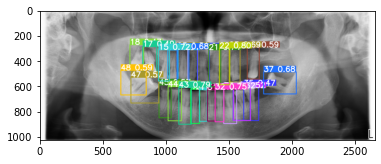

In [211]:
names = np.array(list(model.names.values()))
for result in results:
    print(names[result.boxes.cls.int()])

    res_plotted = result.plot()
    plt.imshow(res_plotted)
    plt.show()



In [212]:
image_labels = {}

for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs

    for i, label in enumerate(labels):
        xyxy = np.hstack(label['points'])  # [x, y, x, y]
        xyxy = xyxy_reformat(np.array([xyxy]))[0]

        for box in boxes:
            # print(box.xyxy)
            tooth_number = names[box.cls.int()]
            tooth_xyxy = box.xyxy
            tooth_xyxy = np.array([np.hstack(tooth_xyxy)]).astype(int)
            tooth_xyxy = xyxy_reformat(tooth_xyxy)[0]

            iou = rect_include_another(tooth_xyxy, xyxy)
            if iou > 0.5:
                # key = f'{filename}-{tooth_number}'
                key = f'{tooth_number}/{filename}'
                if not key in image_labels.keys():
                    image_labels[key] = {}
                image_labels[key][i] = iou

image_labels


{'23/201808060608235842214_000582': {0: tensor(0.93105)},
 '21/201808060608235842214_000582': {1: tensor(1.), 2: tensor(0.94222)},
 '11/201808060608235842214_000582': {2: tensor(0.90944)},
 '12/201808060608235842214_000582': {3: tensor(0.94000)},
 '22/201808060608235842214_000582': {3: tensor(0.91893)},
 '17/201808060608235842214_000582': {4: tensor(1.)}}

In [213]:
import pandas as pd

df = {}
for k, v in image_labels.items():
    df[k] = [v[i].numpy() if i in v.keys() else np.array(0) for i in range(len(labels))]

df = pd.DataFrame(df)
df


,23/201808060608235842214_000582,21/201808060608235842214_000582,11/201808060608235842214_000582,12/201808060608235842214_000582,22/201808060608235842214_000582,17/201808060608235842214_000582
0,0.9310527,0,0,0,0,0
1,0,1.0,0,0,0,0
2,0,0.94222265,0.9094448,0,0,0
3,0,0,0,0.9399997,0.91892827,0
4,0,0,0,0,0,1.0


In [214]:
image_labels_after = {}
max_idxes = df.values.argmax(axis=1)

for i, max_idx in enumerate(max_idxes):
    tooth_key = df.columns[max_idx]
    if not tooth_key in image_labels_after.keys():
        image_labels_after[tooth_key] = {}

    image_labels_after[tooth_key][i] = labels[i]['label']

image_labels_after


{'23/201808060608235842214_000582': {0: 'caries'},
 '21/201808060608235842214_000582': {1: 'caries', 2: 'caries'},
 '12/201808060608235842214_000582': {3: 'caries'},
 '17/201808060608235842214_000582': {4: 'caries'}}

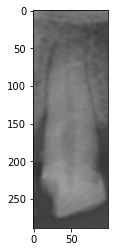

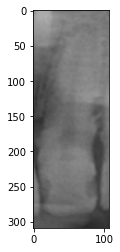

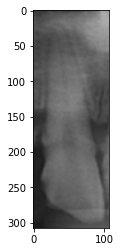

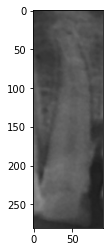

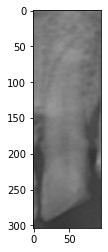

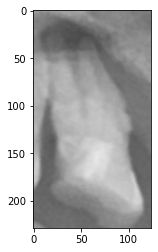

In [219]:
for key, value in image_labels.items():
    im_tooth = cv2.imread(f'./runs/detect/predict2/crops/{key}.jpg')

    plt.imshow(im_tooth)
    plt.show()
